In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Read data

In [2]:
df = pd.read_csv('data/sales_train_v2.csv')
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Print dtypes and memory consumption

In [ ]:
df.info()

Downcast dtypes to save memory

In [3]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

df = downcast_dtypes(df)
#df.info()

# Aggregations

Sum sales for each (item, shop) pair 

In [ ]:
'''grid = []
for date_block in df['date_block_num'].unique():
    
    # cartesian product of shops x items in each month
    cur_shops = df[df['date_block_num'] == date_block]['shop_id'].unique()
    cur_items = df[df['date_block_num'] == date_block]['item_id'].unique()
    grid.append(np.array(list(itertools.product(*[cur_shops, cur_items, [date_block]])),dtype='int32'))'''

In [ ]:
#grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [4]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

In [5]:
df['item_cnt_day'] = df['item_cnt_day'].clip(0,20)
gb_cnt = df.groupby(index_cols)['item_cnt_day'].agg(['sum']).reset_index().rename(columns = {'sum': 'item_cnt_month'})
gb_cnt['item_cnt_month'] = gb_cnt['item_cnt_month'].clip(0,20).astype(np.int)

In [6]:
gb_cnt.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,0,30,1,20
1,0,31,1,11
2,0,32,0,6
3,0,32,1,10
4,0,33,0,3


Join aggregated data to the grid

In [7]:
df = pd.merge(df, gb_cnt, how='left', on=index_cols).fillna(0)
df['item_cnt_month'] = df['item_cnt_month'].astype(int)
df = downcast_dtypes(df)

# Combine all data sources

In [8]:
items = pd.read_csv('data/items.csv')
shops = pd.read_csv('data/shops.csv')
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


Join items with train set

In [9]:
df = pd.merge(df, items[['item_id', 'item_category_id']], on = 'item_id')
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,1,37
1,23.01.2013,0,24,22154,999.0,1.0,1,37
2,20.01.2013,0,27,22154,999.0,1.0,1,37
3,02.01.2013,0,25,22154,999.0,1.0,5,37
4,03.01.2013,0,25,22154,999.0,1.0,5,37


Join items with test set

In [10]:
df_test = pd.read_csv('data/test.csv', delimiter="," ,skiprows=1, usecols = (1,2), dtype=int)
df_test = pd.DataFrame(df_test, columns = ['shop_id', 'item_id'])

df_test = df_test.merge(items[['item_id', 'item_category_id']], on = 'item_id', how = 'left')
df_test['date_block_num'] = 34
df_test['item_cnt_month'] = 0

Concatenate train and test sets, fix category names

In [11]:
df_train_test = pd.concat([df, df_test], axis = 0) 
item_cat = pd.read_csv('data/item_categories.csv')

# Fix category
categories_list = list(item_cat.item_category_name)
for ind in range(0,1):
    categories_list[ind] = 'PC Headsets / Headphones'
for ind in range(1,8):
    categories_list[ind] = 'Access'
categories_list[8] = 'Tickets (figure)'
categories_list[9] = 'Delivery of goods'
for ind in range(10,18):
    categories_list[ind] = 'Consoles'
for ind in range(18,25):
    categories_list[ind] = 'Consoles Games'
categories_list[25] = 'Accessories for games'
for ind in range(26,28):
    categories_list[ind] = 'phone games'
for ind in range(28,32):
    categories_list[ind] = 'CD games'
for ind in range(32,37):
    categories_list[ind] = 'Card'
for ind in range(37,43):
    categories_list[ind] = 'Movie'
for ind in range(43,55):
    categories_list[ind] = 'Books'
for ind in range(55,61):
    categories_list[ind] = 'Music'
for ind in range(61,73):
    categories_list[ind] = 'Gifts'
for ind in range(73,79):
    categories_list[ind] = 'Soft'
for ind in range(79,81):
    categories_list[ind] = 'Office'
for ind in range(81,83):
    categories_list[ind] = 'Clean'
categories_list[83] = 'Elements of a food'

label_encoder = LabelEncoder()
#item_cat['item_category_name_int'] = label_encoder.fit_transform(item_cat['item_category_name'])

item_cat['item_category_id_fix'] = label_encoder.fit_transform(categories_list)
item_cat['item_category_name_fix'] = categories_list
df_train_test = df_train_test.merge(item_cat[['item_category_id', 'item_category_id_fix']], on = 'item_category_id', how = 'left')
_ = df_train_test.drop(['item_category_id'],axis=1, inplace=True)
df_train_test.rename(columns = {'item_category_id_fix':'item_category_id'}, inplace = True)

_ = item_cat.drop(['item_category_id'],axis=1, inplace=True)
_ = item_cat.drop(['item_category_name'],axis=1, inplace=True)

item_cat.rename(columns = {'item_category_id_fix':'item_category_id'}, inplace = True)
item_cat.rename(columns = {'item_category_name_fix':'item_category_name'}, inplace = True)
item_cat = item_cat.drop_duplicates()
item_cat.index = np.arange(0, len(item_cat))


item_cat.head()

/home/sfczekalski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,item_category_id,item_category_name
0,14,PC Headsets / Headphones
1,0,Access
2,16,Tickets (figure)
3,8,Delivery of goods
4,6,Consoles


In [12]:
df_train_test = df_train_test.merge(item_cat, on = 'item_category_id', how = 'left')
df_train_test['item_category_name'].fillna(value='Other', inplace=True)
df_train_test['item_category_id'].fillna(value=-1, inplace=True)
df_train_test.head()

,date,date_block_num,item_cnt_day,item_cnt_month,item_id,item_price,shop_id,item_category_id,item_category_name
0,02.01.2013,0,1.0,1,22154.0,999.0,59.0,11.0,Movie
1,23.01.2013,0,1.0,1,22154.0,999.0,24.0,11.0,Movie
2,20.01.2013,0,1.0,1,22154.0,999.0,27.0,11.0,Movie
3,02.01.2013,0,1.0,5,22154.0,999.0,25.0,11.0,Movie
4,03.01.2013,0,1.0,5,22154.0,999.0,25.0,11.0,Movie


In [13]:
df_train_test['item_cnt_month'] = df_train_test['item_cnt_month'].astype(np.int16)
df_train_test['item_id'].fillna(value=-1, inplace=True)
df_train_test['item_id'] = df_train_test['item_id'].astype(np.int32)
df_train_test['shop_id'].fillna(value=-1, inplace=True)
df_train_test['shop_id'] = df_train_test['shop_id'].astype(np.int32)
df_train_test['item_category_id'] = df_train_test['item_category_id'].astype(np.int16)
df = downcast_dtypes(df_train_test)
df.head()

,date,date_block_num,item_cnt_day,item_cnt_month,item_id,item_price,shop_id,item_category_id,item_category_name
0,02.01.2013,0,1.0,1,22154,999.0,59,11,Movie
1,23.01.2013,0,1.0,1,22154,999.0,24,11,Movie
2,20.01.2013,0,1.0,1,22154,999.0,27,11,Movie
3,02.01.2013,0,1.0,5,22154,999.0,25,11,Movie
4,03.01.2013,0,1.0,5,22154,999.0,25,11,Movie


In [ ]:
df.to_feather('df_preprocessed')

In [ ]:
df = pd.read_feather('df_preprocessed')

Don't use the oldest data. Split the data into train, validation and test set

In [14]:
df = df[df['date_block_num'] >= 12]
df_test = df[df['date_block_num'] == 34]
df_val = df[df['date_block_num'] == 33]
df_train = df[df['date_block_num'] <= 32]

Lag features: number of items sold in previous month for shop, item and category

In [18]:
lag_columns = ['shop_id', 'item_id', 'item_category_id']
lag = 1

for lag_column in lag_columns:

    df_lag = df.groupby([lag_column, 'date_block_num'])['item_cnt_month'].sum().reset_index()
    
    print(f'Grouped by: {lag_column}')
    print(df_lag.head())

    df['merge_month'] = df['date_block_num'] - lag
    df = pd.merge(df, df_lag, how='left', left_on=[lag_column, 'merge_month'], right_on=[lag_column, 'date_block_num']).fillna(0)
    df.rename(columns={'item_cnt_month_y': lag_column + '_lag_' + str(lag)}, inplace=True)
    df.rename(columns={'item_cnt_month_x': 'item_cnt_month'}, inplace=True)
    df.rename(columns={'date_block_num_x': 'date_block_num'}, inplace=True)
    df.drop(columns='date_block_num_y', inplace=True)
    df.drop(columns='merge_month', inplace=True)


df.head()

Grouped by: shop_id
   shop_id  date_block_num  item_cnt_month
0       -1              34             0.0
1        2              12          2927.0
2        2              13          3160.0
3        2              14          3437.0
4        2              15          2528.0
Grouped by: item_id
   item_id  date_block_num  item_cnt_month
0       -1              34               0
1        0              20               1
2        1              15               4
3        1              18               1
4        1              19               1
Grouped by: item_category_id
   item_category_id  date_block_num  item_cnt_month
0                -1              34             0.0
1                 0              12         19536.0
2                 0              13         19203.0
3                 0              14         12386.0
4                 0              15          6396.0


,date,date_block_num,item_cnt_day,item_cnt_month,item_id,item_price,shop_id,item_category_id,item_category_name,shop_id_lag_12,...,item_category_id_lag_12,shop_id_lag_3,item_id_lag_3,item_category_id_lag_3,shop_id_lag_2,item_id_lag_2,item_category_id_lag_2,shop_id_lag_1,item_id_lag_1,item_category_id_lag_1
0,19.07.2015,30,1.0,1,22154,299.0,6,11,Movie,8195.0,...,62340.0,5909.0,0.0,58778.0,4430.0,0.0,42082.0,4913.0,0.0,46974.0
1,25.07.2015,30,1.0,2,22154,299.0,42,11,Movie,12485.0,...,62340.0,15513.0,0.0,58778.0,12805.0,0.0,42082.0,12902.0,0.0,46974.0
2,17.07.2015,30,1.0,2,22154,299.0,42,11,Movie,12485.0,...,62340.0,15513.0,0.0,58778.0,12805.0,0.0,42082.0,12902.0,0.0,46974.0
3,20.07.2015,30,1.0,1,22154,299.0,57,11,Movie,14663.0,...,62340.0,10473.0,0.0,58778.0,7705.0,0.0,42082.0,8593.0,0.0,46974.0
4,18.07.2015,30,1.0,1,22154,299.0,35,11,Movie,5826.0,...,62340.0,4995.0,0.0,58778.0,4205.0,0.0,42082.0,3821.0,0.0,46974.0


Mean item price from previous month

In [19]:
lag = 1

df_lag = df.groupby(['item_id', 'date_block_num'])['item_price'].mean()
df_lag.head()
df['merge_month'] = df['date_block_num'] - lag
df = pd.merge(df, df_lag, how='left', left_on=['item_id', 'merge_month'], right_on=['item_id', 'date_block_num']).fillna(0)
df.rename(columns={'item_price_y': 'previous_month_price'}, inplace=True)
df.rename(columns={'item_price_x': 'item_price'}, inplace=True)
df.drop(columns='merge_month', inplace=True)

In [ ]:
df.head()

Lag feature: monthly count for (item, shop) pairs

In [23]:
lag = 12

df_lag = df.groupby(['item_id', 'shop_id', 'date_block_num'])['item_cnt_month'].sum()
df['merge_month'] = df['date_block_num'] - lag
df = pd.merge(df, df_lag, how='left', left_on=['item_id', 'shop_id', 'merge_month'], right_on=['item_id', 'shop_id', 'date_block_num']).fillna(0)
df.rename(columns={'item_cnt_month_y': 'item_shop_lag_' + str(lag)}, inplace=True)
df.rename(columns={'item_cnt_month_x': 'item_cnt_month'}, inplace=True)
df.drop(columns='merge_month', inplace=True)

In [25]:
df.to_csv('df_preprocessed.csv')

In [63]:
small_idx = np.random.permutation(range(1882486))[:40000]
small_df = df.iloc[small_idx]
small_df = small_df.reset_index()
valid_idx = small_df[small_df['date_block_num'] == 33].index.values

In [68]:
from fastai.tabular import *

#df = downcast_dtypes(df)


procs=[Categorify, Normalize]

cat_vars = ['shop_id', 'item_id', 'item_category_id']
cont_vars = ['item_price', 'shop_id_lag_1',
            'item_id_lag_1', 'item_category_id_lag_1', 'shop_id_lag_2',
            'item_id_lag_2', 'item_category_id_lag_2', 'shop_id_lag_3',
            'item_id_lag_3', 'item_category_id_lag_3', 'shop_id_lag_12',
            'item_id_lag_12', 'item_category_id_lag_12', 'previous_month_price',
            'item_shop_lag_1', 'item_shop_lag_2', 'item_shop_lag_3', 'date_block_num']

dep_var = 'item_cnt_month'
small_df = small_df[cat_vars + cont_vars + [dep_var]]

In [69]:
path = 'data'

In [70]:
data = (TabularList.from_df(small_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .databunch())

In [71]:
emb_szs= {
            'shop_id': 15,
            'item_id': 15,
            'item_category_id': 10,
        }

In [109]:
y_range = torch.tensor([0, 20.5], device=defaults.device)

In [126]:
learn = tabular_learner(data, layers=[800,400], ps=[0.001,0.01], emb_drop=0.04, y_range=y_range, metrics=rmse)

In [127]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(56, 15)
    (1): Embedding(7099, 230)
    (2): Embedding(19, 8)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=271, out_features=800, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=800, out_features=400, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=400, out_features=1, bias=True)
  )
)

In [128]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


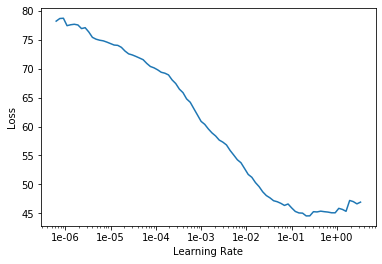

In [129]:
learn.recorder.plot()

In [131]:
learn.fit_one_cycle(5, 5e-3, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,13.353676,20.768213,4.498091,00:32
1,10.370371,16.369360,4.010324,00:35
2,7.887416,17.928831,4.184150,00:38
3,6.418590,18.441664,4.238008,00:34
4,4.814075,17.716661,4.153220,00:31


In [115]:
learn.save('1')

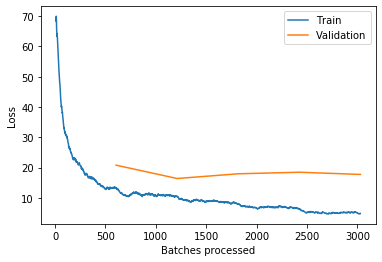

In [132]:
learn.recorder.plot_losses(skip_start=10)

In [83]:
preds = learn.get_preds()[0].numpy()